In [1]:
from z3 import *
import numpy as np
import re
import arviz as az

import os, sys
sys.path.append(os.path.join("../../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

# MCMC with SAT Sampler as Proposal Distribution

In this notebook, we show how to use the SAT sampler `spur` to generate proposal samples for the Metropolis-Hastings algorithm.

## Model definition (in Z3)

We start by defining the model in Z3. It must be an SMT model using bit-vectors (BitVec). Instead of using a Z3 `Solver` object, we must use a `Goal` object. This is needed to later bit-blast automatically the SMT problem.

In [2]:
# Assumption, all bit-vectors are of the same size
## NOTE: It looks like we need to always have one extra bit? For the sign?
num_bits = 4
num_vars = 3
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2]])) # important
g.add(ULE(0,x[0]))
g.add(ULE(x[0],3))
g.add(ULE(0,x[1]))
g.add(ULE(x[1],3))
g.add(ULE(0,x[2]))
g.add(ULE(x[2],6))
g.add(x[0] + x[1]  == x[2])

In [3]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=30000,
                                           num_chains=4)

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 30000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fo

c Number of samples found until now:  13210
c Number of samples found until now:  13220
c Number of samples found until now:  13230
c Number of samples found until now:  13240
c Number of samples found until now:  13250
c Number of samples found until now:  13260
c Number of samples found until now:  13270
c Number of samples found until now:  13280
c Number of samples found until now:  13290
c Number of samples found until now:  13300
c Number of samples found until now:  13310
c Number of samples found until now:  13320
c Number of samples found until now:  13330
c Number of samples found until now:  13340
c Number of samples found until now:  13350
c Number of samples found until now:  13360
c Number of samples found until now:  13370
c Number of samples found until now:  13380
c Number of samples found until now:  13390
c Number of samples found until now:  13400
c Number of samples found until now:  13410
c Number of samples found until now:  13420
c Number of samples found until 

c Number of samples found until now:  26080
c Number of samples found until now:  26090
c Number of samples found until now:  26100
c Number of samples found until now:  26110
c Number of samples found until now:  26120
c Number of samples found until now:  26130
c Number of samples found until now:  26140
c Number of samples found until now:  26150
c Number of samples found until now:  26160
c Number of samples found until now:  26170
c Number of samples found until now:  26180
c Number of samples found until now:  26190
c Number of samples found until now:  26200
c Number of samples found until now:  26210
c Number of samples found until now:  26220
c Number of samples found until now:  26230
c Number of samples found until now:  26240
c Number of samples found until now:  26250
c Number of samples found until now:  26260
c Number of samples found until now:  26270
c Number of samples found until now:  26280
c Number of samples found until now:  26290
c Number of samples found until 

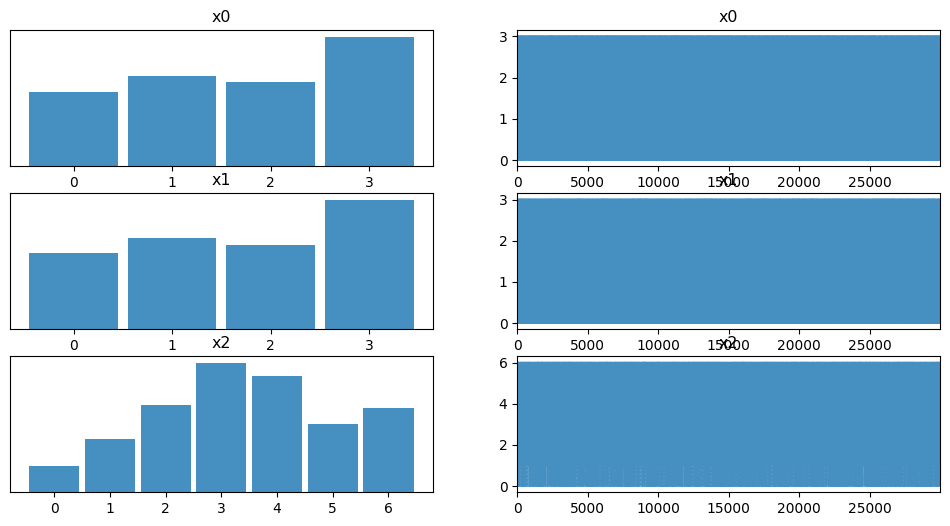

In [4]:
# Trace plot
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('cmsgen_triangle_trace_plot.png',dpi=150);

# Diagnosis
az.summary(trace)

In [5]:
utils.save_trace(trace, f'triangle_SAT_cmsgen_{num_vars}_{num_bits}.nc')

In [6]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist()) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist()) for i in range(0,7)])

[(0, 0.19616666666666666), (1, 0.23883333333333334), (2, 0.22313333333333332), (3, 0.34186666666666665)]
[(0, 0.04636666666666667), (1, 0.0944), (2, 0.15433333333333332), (3, 0.2291), (4, 0.20553333333333335), (5, 0.12083333333333333), (6, 0.14943333333333333)]


## Non-uniform prior

Here we use the `f` parameter of our MH function to specify a prior for the variables of the SMT problem.

In particular, we consider the following very simple model

$$
x_0 \sim \mathit{Cat}(1/3, 1/3, 1/6, 1/6) ~~
x_1 \sim \mathit{U}(0,3) ~~
x_2 = x_0 + x_1
$$


In [7]:
def prior(s: dict[str, int]):
    x0 = s['x0']
    x1 = s['x1']
    p_x0 = 1/3 if x0 < 2 else 1/6
    p_x1 = 1/4

    return p_x0 * p_x1

def likelihood(s: dict[str, int]):
    return 1

In [8]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=30000,
                                           num_chains=4,
                                           f= lambda s: prior(s)*likelihood(s))

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 30000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fo

c Number of samples found until now:   6860
c Number of samples found until now:   6870
c Number of samples found until now:   6880
c Number of samples found until now:   6890
c Number of samples found until now:   6900
c Number of samples found until now:   6910
c Number of samples found until now:   6920
c Number of samples found until now:   6930
c Number of samples found until now:   6940
c Number of samples found until now:   6950
c Number of samples found until now:   6960
c Number of samples found until now:   6970
c Number of samples found until now:   6980
c Number of samples found until now:   6990
c Number of samples found until now:   7000
c Number of samples found until now:   7010
c Number of samples found until now:   7020
c Number of samples found until now:   7030
c Number of samples found until now:   7040
c Number of samples found until now:   7050
c Number of samples found until now:   7060
c Number of samples found until now:   7070
c Number of samples found until 

c Number of samples found until now:  12810
c Number of samples found until now:  12820
c Number of samples found until now:  12830
c Number of samples found until now:  12840
c Number of samples found until now:  12850
c Number of samples found until now:  12860
c Number of samples found until now:  12870
c Number of samples found until now:  12880
c Number of samples found until now:  12890
c Number of samples found until now:  12900
c Number of samples found until now:  12910
c Number of samples found until now:  12920
c Number of samples found until now:  12930
c Number of samples found until now:  12940
c Number of samples found until now:  12950
c Number of samples found until now:  12960
c Number of samples found until now:  12970
c Number of samples found until now:  12980
c Number of samples found until now:  12990
c Number of samples found until now:  13000
c Number of samples found until now:  13010
c Number of samples found until now:  13020
c Number of samples found until 

c Number of samples found until now:  17830
c Number of samples found until now:  17840
c Number of samples found until now:  17850
c Number of samples found until now:  17860
c Number of samples found until now:  17870
c Number of samples found until now:  17880
c Number of samples found until now:  17890
c Number of samples found until now:  17900
c Number of samples found until now:  17910
c Number of samples found until now:  17920
c Number of samples found until now:  17930
c Number of samples found until now:  17940
c Number of samples found until now:  17950
c Number of samples found until now:  17960
c Number of samples found until now:  17970
c Number of samples found until now:  17980
c Number of samples found until now:  17990
c Number of samples found until now:  18000
c Number of samples found until now:  18010
c Number of samples found until now:  18020
c Number of samples found until now:  18030
c Number of samples found until now:  18040
c Number of samples found until 

c Number of samples found until now:  24740
c Number of samples found until now:  24750
c Number of samples found until now:  24760
c Number of samples found until now:  24770
c Number of samples found until now:  24780
c Number of samples found until now:  24790
c Number of samples found until now:  24800
c Number of samples found until now:  24810
c Number of samples found until now:  24820
c Number of samples found until now:  24830
c Number of samples found until now:  24840
c Number of samples found until now:  24850
c Number of samples found until now:  24860
c Number of samples found until now:  24870
c Number of samples found until now:  24880
c Number of samples found until now:  24890
c Number of samples found until now:  24900
c Number of samples found until now:  24910
c Number of samples found until now:  24920
c Number of samples found until now:  24930
c Number of samples found until now:  24940
c Number of samples found until now:  24950
c Number of samples found until 

### Posterior analysis

We observe the in the traceplot below the effect of the prior on $x_0$. Now it is distributed as according to the categorical distribution above. As opposed to the uniform prior we used in the previous analysis.

The distribution of $x_2$ is also affected by the new prior on $x_0$.

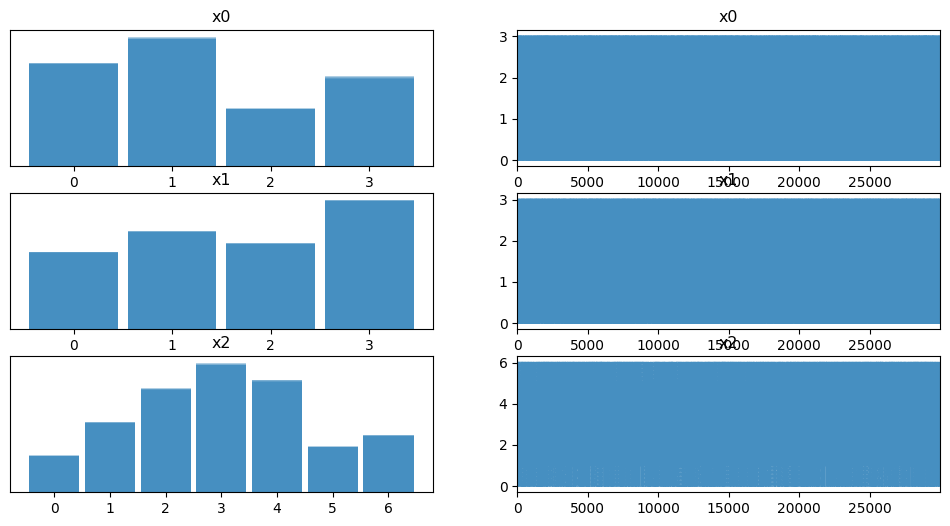

In [9]:
az.plot_trace(trace);
plt.savefig('cmsgen_trace_plot_non_uniform.png',dpi=150);

Here we plot the probability of each outcome for $x_0$ and $x_2$. Note that due to the lack of uniformity in sampling, the posterior is a bit imprecise. For instance, in x0 we should expect the probability of 3 to be lower.

In [10]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist()) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist()) for i in range(0,7)])

[(0, 0.27248333333333336), (1, 0.33974166666666666), (2, 0.15235833333333335), (3, 0.23541666666666666)]
[(0, 0.06636666666666667), (1, 0.12669166666666667), (2, 0.18754166666666666), (3, 0.2321), (4, 0.20203333333333334), (5, 0.08205833333333333), (6, 0.10320833333333333)]


Finally, we compare the estimated values with the analytical solution to this problem.

In [11]:
real_value_x0 = [1/3, 1/3, 1/6, 1/6]
real_value_x2 = [1/12, 1/6, 5/24, 1/4, 1/6, 1/12, 1/24]

In [12]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist() - real_value_x0[i]) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist() - real_value_x2[i]) for i in range(0,7)])

[(0, -0.06084999999999996), (1, 0.006408333333333349), (2, -0.014308333333333312), (3, 0.06875)]
[(0, -0.016966666666666658), (1, -0.03997499999999998), (2, -0.02079166666666668), (3, -0.0179), (4, 0.035366666666666685), (5, -0.0012749999999999984), (6, 0.06154166666666667)]


The error is low ($< 0.08$ for x0 and $< 0.07$ for x2 for all outcomes). However, I should remark that in other executions I observed errors up to 0.13...

In [13]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.351,1.115,0.0,3.0,0.004,0.003,69615.0,67511.0,1.0
x1,1.685,1.128,0.0,3.0,0.004,0.003,79327.0,78725.0,1.0
x2,3.036,1.658,0.0,6.0,0.006,0.004,72751.0,65331.0,1.0


In [14]:
utils.save_trace(trace, f'triangle_prior_SAT_cmsgen_{num_vars}_{num_bits}.nc')